# Probability Based Trading
<br/><br/>
### Using a classifier's probability as a threshold for a trade

In [1]:
# Importing packages
import pandas as pd
import numpy as np
import time
import datetime
from datetime import date
import pandas_datareader.data as web

# List of stock tickers
symbols = ['BTC-USD', 'ETH-USD', 'XRP-USD', 'USDT-USD', 'LINK-USD', 'BCH-USD', 'LTC-USD', 'BNB-USD',
           'EOS-USD', 'XLM-USD', 'TRX-USD', 'XMR-USD', 'MIOTA-USD', 'NEO-USD', 'DASH-USD', 'ZEC-USD',
           'XEM-USD', 'DOGE-USD', 'DGB-USD', 'BAT-USD', 'KNC-USD', 'WAVES-USD', 'ZRX-USD', 'QTUM-USD']
print('There are', len(symbols), 'symbols!')
# Defining start and end dates
start = datetime.date(2015, 1, 1)
end = None

# Create a dictionary with key value pair of symbol and symbol data
data = {}
for i in symbols:
    try:
        data[i] = web.DataReader(i, 'yahoo', start, end)
        data[i].insert(0,'Symbol',i)
        print ('Done', i, data[i].index[0])
    except :
        print('No information for ticker: {}'.format(i))
        continue

There are 24 symbols!
Done BTC-USD 2015-01-01 00:00:00
Done ETH-USD 2015-08-06 00:00:00
Done XRP-USD 2015-01-01 00:00:00
Done USDT-USD 2015-02-25 00:00:00
Done LINK-USD 2017-09-19 00:00:00
Done BCH-USD 2017-07-22 00:00:00
Done LTC-USD 2015-01-01 00:00:00
Done BNB-USD 2017-07-24 00:00:00
Done EOS-USD 2017-06-30 00:00:00
Done XLM-USD 2015-01-01 00:00:00
Done TRX-USD 2017-09-12 00:00:00
Done XMR-USD 2015-01-01 00:00:00
Done MIOTA-USD 2017-06-12 00:00:00
Done NEO-USD 2016-09-08 00:00:00
Done DASH-USD 2015-01-01 00:00:00
Done ZEC-USD 2016-10-28 00:00:00
Done XEM-USD 2015-03-31 00:00:00
Done DOGE-USD 2015-01-01 00:00:00
Done DGB-USD 2015-01-01 00:00:00
Done BAT-USD 2017-05-31 00:00:00
Done KNC-USD 2017-09-23 00:00:00
Done WAVES-USD 2016-06-01 00:00:00
Done ZRX-USD 2017-08-15 00:00:00
Done QTUM-USD 2017-05-23 00:00:00


In [2]:
# Creating new features
for i in range(len(data)):
    data[symbols[i]]['High-Low'] = data[symbols[i]]['High'] - data[symbols[i]]['Low']
    data[symbols[i]]['HL-Perc'] = 100*data[symbols[i]]['High-Low']/data[symbols[i]]['Close']
    data[symbols[i]]['Open-PrevClose-Perc'] = (data[symbols[i]]['Open'] - data[symbols[i]]['Close'].shift(1))/(0.01*data[symbols[i]]['Close'].shift(1))

In [3]:
# Creating for features
short_window=40
long_window=100

for i in range(len(data)):
    data[symbols[i]]['short_mavg'] = data[symbols[i]]['Adj Close'].rolling(window=short_window, min_periods=1, center=False).mean()

    data[symbols[i]]['long_mavg'] = data[symbols[i]]['Adj Close'].rolling(window=long_window, min_periods=1, center=False).mean()
    
    data[symbols[i]]['short > long'] = 0
    for j in range(len(data[symbols[i]])):
        if data[symbols[i]]['short_mavg'].iloc[j] > data[symbols[i]]['long_mavg'].iloc[j]:
            data[symbols[i]]['short > long'].iloc[j] = 1
    
    data[symbols[i]]['sl-diff'] = data[symbols[i]]['short > long'].diff()
    
    data[symbols[i]]['return'] = 100*(data[symbols[i]]['Adj Close'] - data[symbols[i]]['Adj Close'].shift(1))/data[symbols[i]]['Adj Close'].shift(1)

/Users/patrickfahy99/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [4]:
# Shift up to make sure we are predicting what will happen the next day

for i in range(len(data)):
    data[symbols[i]]['up'] = 0
    for j in range(len(data[symbols[i]])):
        if data[symbols[i]]['Adj Close'].iloc[j] > data[symbols[i]]['Adj Close'].iloc[j-1]:
            data[symbols[i]]['up'].iloc[j] = 1
    data[symbols[i]]['up'] = data[symbols[i]]['up'].shift(-1)

In [5]:
for i in range(len(data)):    
    data[symbols[i]]['BollingerBand_Up_20_2'] = data[symbols[i]]['Adj Close'].rolling(20).mean() + 2*data[symbols[i]]['Adj Close'].rolling(20).std()
    data[symbols[i]]['BollingerBand_Down_20_2'] = data[symbols[i]]['Adj Close'].rolling(20).mean() - 2*data[symbols[i]]['Adj Close'].rolling(20).std()
    data[symbols[i]]['BollingerBand_Up_20_1'] = data[symbols[i]]['Adj Close'].rolling(20).mean() + data[symbols[i]]['Adj Close'].rolling(20).std()
    data[symbols[i]]['BollingerBand_Down_20_1'] = data[symbols[i]]['Adj Close'].rolling(20).mean() - data[symbols[i]]['Adj Close'].rolling(20).std()
    data[symbols[i]]['BollingerBand_Up_10_1'] = data[symbols[i]]['Adj Close'].rolling(10).mean() + data[symbols[i]]['Adj Close'].rolling(10).std()
    data[symbols[i]]['BollingerBand_Down_10_1'] = data[symbols[i]]['Adj Close'].rolling(10).mean() - data[symbols[i]]['Adj Close'].rolling(10).std()
    data[symbols[i]]['BollingerBand_Up_10_2'] = data[symbols[i]]['Adj Close'].rolling(10).mean() + 2*data[symbols[i]]['Adj Close'].rolling(10).std()
    data[symbols[i]]['BollingerBand_Down_10_2'] = data[symbols[i]]['Adj Close'].rolling(10).mean() - 2*data[symbols[i]]['Adj Close'].rolling(10).std()

In [6]:
# Drop null values and at which date I want to start looking at
for i in range(len(data)):
    data[symbols[i]] = data[symbols[i]].dropna()
    data[symbols[i]] = data[symbols[i]][data[symbols[i]].index > '2017-11-15 00:00:00']

In [7]:
data2 = data.copy()

In [8]:
# Feature scaling 
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
for i in range(len(data)):
    scaler = data[symbols[i]].drop(['Symbol','up', 'short > long', 'sl-diff'], axis=1)
    scaler = pd.DataFrame(sc.fit_transform(scaler), columns = scaler.columns, index=scaler.index)
    scaler['Symbol'] = data[symbols[i]]['Symbol']
    scaler['up'] = data[symbols[i]]['up']
    scaler['short > long'] = data[symbols[i]]['short > long']
    scaler['sl-diff'] = data[symbols[i]]['sl-diff']
    data[symbols[i]] = scaler

In [9]:
# Creating a dataframe of all previous stock data
df = pd.DataFrame()
for i in range(len(data)):
    df = df.append(data[symbols[i]])
df

,High,Low,Open,Close,Volume,Adj Close,High-Low,HL-Perc,Open-PrevClose-Perc,short_mavg,...,BollingerBand_Up_20_1,BollingerBand_Down_20_1,BollingerBand_Up_10_1,BollingerBand_Down_10_1,BollingerBand_Up_10_2,BollingerBand_Down_10_2,Symbol,up,short > long,sl-diff
Date,,,,,,,,,,,,,,,,,,,,,
2017-11-16,-0.148902,-0.308319,-0.318513,-0.118316,-0.926113,-0.118316,0.788920,1.213089,0.290307,-0.773316,...,-0.457237,-0.566188,-0.375658,-0.587252,-0.287977,-0.704688,BTC-USD,0.0,1,0.0
2017-11-17,-0.135795,-0.159062,-0.123794,-0.178025,-0.964353,-0.178025,0.051456,0.225564,-0.651849,-0.742232,...,-0.432675,-0.513768,-0.338635,-0.585120,-0.237884,-0.724547,BTC-USD,1.0,1,0.0
2017-11-18,-0.177921,-0.196967,-0.181204,-0.148240,-1.044088,-0.148240,0.004848,0.146965,-0.434514,-0.711955,...,-0.404162,-0.479841,-0.314672,-0.586571,-0.204359,-0.741936,BTC-USD,1.0,1,0.0
2017-11-19,-0.101517,-0.107431,-0.155936,-0.057836,-1.086031,-0.057836,-0.024329,0.069482,-0.874937,-0.679307,...,-0.369530,-0.442092,-0.257329,-0.581777,-0.127353,-0.770304,BTC-USD,1.0,1,0.0
2017-11-20,-0.018762,-0.008346,-0.055685,0.002405,-1.058564,0.002405,-0.067454,-0.010851,0.084830,-0.645458,...,-0.329382,-0.418595,-0.183638,-0.540393,-0.042113,-0.750328,BTC-USD,0.0,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-03,-0.438105,-0.448491,-0.442593,-0.441822,-0.467747,-0.441822,-0.293717,-0.749388,-0.003397,-0.457581,...,-0.449010,-0.453479,-0.444794,-0.446263,-0.438601,-0.427077,QTUM-USD,0.0,1,0.0
2020-10-04,-0.437435,-0.448004,-0.442452,-0.442092,-0.461939,-0.442092,-0.292570,-0.727553,-0.003397,-0.460336,...,-0.450666,-0.454639,-0.444758,-0.446619,-0.438442,-0.427734,QTUM-USD,0.0,1,0.0
2020-10-05,-0.438673,-0.456179,-0.442948,-0.453175,-0.288454,-0.453175,-0.269226,-0.242253,-0.237439,-0.464040,...,-0.451032,-0.457280,-0.443939,-0.451566,-0.435817,-0.437128,QTUM-USD,1.0,1,0.0


In [10]:
# Encode symbols so a ML algorithm will work.
df = pd.get_dummies(data=df, columns=['Symbol'])
df

,High,Low,Open,Close,Volume,Adj Close,High-Low,HL-Perc,Open-PrevClose-Perc,short_mavg,...,Symbol_QTUM-USD,Symbol_TRX-USD,Symbol_USDT-USD,Symbol_WAVES-USD,Symbol_XEM-USD,Symbol_XLM-USD,Symbol_XMR-USD,Symbol_XRP-USD,Symbol_ZEC-USD,Symbol_ZRX-USD
Date,,,,,,,,,,,,,,,,,,,,,
2017-11-16,-0.148902,-0.308319,-0.318513,-0.118316,-0.926113,-0.118316,0.788920,1.213089,0.290307,-0.773316,...,0,0,0,0,0,0,0,0,0,0
2017-11-17,-0.135795,-0.159062,-0.123794,-0.178025,-0.964353,-0.178025,0.051456,0.225564,-0.651849,-0.742232,...,0,0,0,0,0,0,0,0,0,0
2017-11-18,-0.177921,-0.196967,-0.181204,-0.148240,-1.044088,-0.148240,0.004848,0.146965,-0.434514,-0.711955,...,0,0,0,0,0,0,0,0,0,0
2017-11-19,-0.101517,-0.107431,-0.155936,-0.057836,-1.086031,-0.057836,-0.024329,0.069482,-0.874937,-0.679307,...,0,0,0,0,0,0,0,0,0,0
2017-11-20,-0.018762,-0.008346,-0.055685,0.002405,-1.058564,0.002405,-0.067454,-0.010851,0.084830,-0.645458,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-03,-0.438105,-0.448491,-0.442593,-0.441822,-0.467747,-0.441822,-0.293717,-0.749388,-0.003397,-0.457581,...,1,0,0,0,0,0,0,0,0,0
2020-10-04,-0.437435,-0.448004,-0.442452,-0.442092,-0.461939,-0.442092,-0.292570,-0.727553,-0.003397,-0.460336,...,1,0,0,0,0,0,0,0,0,0
2020-10-05,-0.438673,-0.456179,-0.442948,-0.453175,-0.288454,-0.453175,-0.269226,-0.242253,-0.237439,-0.464040,...,1,0,0,0,0,0,0,0,0,0


In [11]:
pd.set_option('display.max_columns', None)
df

,High,Low,Open,Close,Volume,Adj Close,High-Low,HL-Perc,Open-PrevClose-Perc,short_mavg,long_mavg,return,BollingerBand_Up_20_2,BollingerBand_Down_20_2,BollingerBand_Up_20_1,BollingerBand_Down_20_1,BollingerBand_Up_10_1,BollingerBand_Down_10_1,BollingerBand_Up_10_2,BollingerBand_Down_10_2,up,short > long,sl-diff,Symbol_BAT-USD,Symbol_BCH-USD,Symbol_BNB-USD,Symbol_BTC-USD,Symbol_DASH-USD,Symbol_DGB-USD,Symbol_DOGE-USD,Symbol_EOS-USD,Symbol_ETH-USD,Symbol_KNC-USD,Symbol_LINK-USD,Symbol_LTC-USD,Symbol_MIOTA-USD,Symbol_NEO-USD,Symbol_QTUM-USD,Symbol_TRX-USD,Symbol_USDT-USD,Symbol_WAVES-USD,Symbol_XEM-USD,Symbol_XLM-USD,Symbol_XMR-USD,Symbol_XRP-USD,Symbol_ZEC-USD,Symbol_ZRX-USD
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-11-16,-0.148902,-0.308319,-0.318513,-0.118316,-0.926113,-0.118316,0.788920,1.213089,0.290307,-0.773316,-1.388126,1.800915,-0.407501,-0.607967,-0.457237,-0.566188,-0.375658,-0.587252,-0.287977,-0.704688,0.0,1,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2017-11-17,-0.135795,-0.159062,-0.123794,-0.178025,-0.964353,-0.178025,0.051456,0.225564,-0.651849,-0.742232,-1.367795,-0.528118,-0.393453,-0.539749,-0.432675,-0.513768,-0.338635,-0.585120,-0.237884,-0.724547,1.0,1,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2017-11-18,-0.177921,-0.196967,-0.181204,-0.148240,-1.044088,-0.148240,0.004848,0.146965,-0.434514,-0.711955,-1.347267,0.223325,-0.367550,-0.504065,-0.404162,-0.479841,-0.314672,-0.586571,-0.204359,-0.741936,1.0,1,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2017-11-19,-0.101517,-0.107431,-0.155936,-0.057836,-1.086031,-0.057836,-0.024329,0.069482,-0.874937,-0.679307,-1.326846,0.731421,-0.334855,-0.466316,-0.369530,-0.442092,-0.257329,-0.581777,-0.127353,-0.770304,1.0,1,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2017-11-20,-0.018762,-0.008346,-0.055685,0.002405,-1.058564,0.002405,-0.067454,-0.010851,0.084830,-0.645458,-1.306751,0.461729,-0.289730,-0.455300,-0.329382,-0.418595,-0.183638,-0.540393,-0.042113,-0.750328,0.0,1,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-03,-0.438105,-0.448491,-0.442593,-0.441822,-0.467747,-0.441822,-0.293717,-0.749388,-0.003397,-0.457581,-0.545421,-0.002935,-0.441065,-0.417579,-0.449010,-0.453479,-0.444794,-0.446263,-0.438601,-0.427077,0.0,1,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2020-10-04,-0.437435,-0.448004,-0.442452,-0.442092,-0.461939,-0.442092,-0.292570,-0.727553,-0.003397,-0.460336,-0.544813,-0.031937,-0.442828,-0.418142,-0.450666,-0.454639,-0.444758,-0.446619,-0.438442,-0.427734,0.0,1,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2020-10-05,-0.438673,-0.456179,-0.442948,-0.453175,-0.288454,-0.453175,-0.269226,-0.242253,-0.237439,-0.464040,-0.544294,-0.794692,-0.442583,-0.422812,-0.451032,-0.457280,-0.443939,-0.451566,-0.435817,-0.437128,1.0,1,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [12]:
def accuracy_for_threshold(thresh, real, predicted):
    total=0
    num=0
    for i in range(len(predicted)):
        if thresh <= predicted[i] <= (1-thresh):
            continue
        else:
            total += 1
            num += 1 - abs(round(predicted[i]) - real[i]) 
    return num/total

In [13]:
# Import ML models
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from sklearn.metrics import roc_curve, auc
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

mdls = [
    #Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(max_depth=2),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(max_depth=3),
    
    #GLM
    linear_model.LogisticRegressionCV(),
    
    #Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    
    #Trees    
    tree.DecisionTreeClassifier(max_depth=3),
    tree.ExtraTreeClassifier(),
    
    #Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),
    
    XGBClassifier(max_depth=2)
    ]

cutoff_date = '2020-4-1'
end_date = '2020-7-1'

train = df[df.index < cutoff_date]
val = df[np.logical_and(df.index >= cutoff_date, df.index <= end_date)]

X_train, X_test = train.drop(['up'], axis=1), val.drop(['up'], axis=1)
y_train, y_test = train['up'], val['up']

models = []
models_output = []

for mdl in mdls:
    mdl.fit(X_train, y_train)

    accuracy_train = accuracy_for_threshold(0.55, y_train, mdl.predict_proba(X_train)[:, 1])
    accuracy_test = accuracy_for_threshold(0.55, y_test, mdl.predict_proba(X_test)[:, 1])

    print('\nTrain Accuracy:{: .2f}%'.format(accuracy_train*100), mdl)
    print('Test Accuracy:{: .2f}%'.format(accuracy_test*100), mdl)
    
    if accuracy_train>0.55 and accuracy_test>0.55:
        models_output.append((str(mdl).split('(')[0], 0.25*accuracy_train + 0.75*accuracy_test))
        models.append(mdl)
print(sorted(models_output, key = lambda x: x[1], reverse=True))


Train Accuracy: 57.24% AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)
Test Accuracy: 55.25% AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)

Train Accuracy: 98.29% BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False,
                  max_features=1.0, max_samples=1.0, n_estimators=10,
                  n_jobs=None, oob_score=False, random_state=None, verbose=0,
                  warm_start=False)
Test Accuracy: 51.31% BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False,
                  max_features=1.0, max_samples=1.0, n_estimators=10,
                  n_jobs=None, oob_score=False, random_state=None, verbose=0,
                  warm_start=False)

Train Accuracy: 52.28% ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
            

/Users/patrickfahy99/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/patrickfahy99/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stabl


Train Accuracy: 55.44% LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='auto', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)
Test Accuracy: 53.94% LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='auto', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

Train Accuracy: 51.50% BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)
Test Accuracy: 52.99% BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

Train Accuracy: 51.35% GaussianNB(priors=None, var_sm

/Users/patrickfahy99/opt/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")



Train Accuracy: 54.66% QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
                              store_covariance=False, tol=0.0001)
Test Accuracy: 51.49% QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
                              store_covariance=False, tol=0.0001)

Train Accuracy: 59.69% XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
Test Accuracy: 56.30% XGBClassifier(base_score=0.5, boost

In [14]:
mask = np.logical_and(datetime.datetime(2020, 9, 30) >= pd.to_datetime(data2[symbols[i]].index),
                        pd.to_datetime(data2[symbols[i]].index) >= datetime.datetime(2020, 7, 1))

In [15]:
test = {}
for i in symbols:
    mask = np.logical_and(datetime.datetime(2020, 9, 30) >= pd.to_datetime(data2[i].index),
                        pd.to_datetime(data2[i].index) >= datetime.datetime(2020, 7, 1))
    test[i] = data2[i][mask]



In [16]:
X_backtest = df[np.logical_and(df.index <= '2020-9-1', df.index >= end_date)].drop('up', axis=1)

In [17]:
X_backtest

,High,Low,Open,Close,Volume,Adj Close,High-Low,HL-Perc,Open-PrevClose-Perc,short_mavg,long_mavg,return,BollingerBand_Up_20_2,BollingerBand_Down_20_2,BollingerBand_Up_20_1,BollingerBand_Down_20_1,BollingerBand_Up_10_1,BollingerBand_Down_10_1,BollingerBand_Up_10_2,BollingerBand_Down_10_2,short > long,sl-diff,Symbol_BAT-USD,Symbol_BCH-USD,Symbol_BNB-USD,Symbol_BTC-USD,Symbol_DASH-USD,Symbol_DGB-USD,Symbol_DOGE-USD,Symbol_EOS-USD,Symbol_ETH-USD,Symbol_KNC-USD,Symbol_LINK-USD,Symbol_LTC-USD,Symbol_MIOTA-USD,Symbol_NEO-USD,Symbol_QTUM-USD,Symbol_TRX-USD,Symbol_USDT-USD,Symbol_WAVES-USD,Symbol_XEM-USD,Symbol_XLM-USD,Symbol_XMR-USD,Symbol_XRP-USD,Symbol_ZEC-USD,Symbol_ZRX-USD
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-07-01,0.311659,0.413700,0.382002,0.341052,-0.017776,0.341052,-0.384185,-0.496860,0.080335,0.523511,0.268867,-0.304104,0.109783,0.902879,0.260786,0.667065,0.278343,0.520080,0.180288,0.658248,1,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-07-02,0.286081,0.422307,0.342974,0.327802,-0.281806,0.327802,-0.585465,-0.734413,0.038780,0.526490,0.280071,-0.125588,0.106524,0.890060,0.255649,0.656998,0.232145,0.530551,0.112665,0.704066,1,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-07-03,0.279372,0.420302,0.328063,0.344384,-0.345664,0.344384,-0.614946,-0.771181,-0.100217,0.528753,0.291320,0.089506,0.104607,0.881328,0.252404,0.650246,0.220001,0.530180,0.096107,0.711107,1,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-07-04,0.271935,0.390562,0.343432,0.322898,-0.296026,0.322898,-0.497092,-0.628376,-0.202071,0.531149,0.303445,-0.184678,0.100496,0.870310,0.246882,0.641134,0.210098,0.526385,0.083963,0.711252,1,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-07-05,0.347061,0.422256,0.323883,0.433557,0.107790,0.433557,-0.217559,-0.320490,-0.039147,0.533100,0.318034,0.770166,0.092680,0.874690,0.241099,0.641442,0.231133,0.518833,0.115837,0.685929,1,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-28,-0.345264,-0.355644,-0.354870,-0.344731,0.554333,-0.344731,-0.223793,-0.030144,-0.073670,-0.434232,-0.575386,0.441880,-0.349323,-0.356865,-0.358899,-0.374583,-0.325252,-0.333163,-0.318570,-0.324361,1,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2020-08-29,-0.333802,-0.340246,-0.346401,-0.344490,0.642823,-0.344490,-0.228933,-0.094619,-0.665861,-0.431427,-0.573389,-0.001480,-0.349602,-0.348725,-0.358127,-0.369911,-0.331008,-0.337964,-0.324553,-0.328169,1,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2020-08-30,-0.344015,-0.343909,-0.345538,-0.351854,0.634300,-0.351854,-0.259550,-0.454597,-0.233975,-0.429085,-0.571744,-0.359936,-0.351953,-0.333890,-0.358378,-0.362259,-0.333233,-0.343396,-0.325738,-0.335953,1,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [18]:
import warnings
import numpy as np
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

predictions = []
for mdl in models:
    pred = list(mdl.predict_proba(X_backtest)[:,0])
    predictions.append(pred)

In [19]:
models_output

[('AdaBoostClassifier', 0.5574993321311694),
 ('GradientBoostingClassifier', 0.5726166474654377),
 ('XGBClassifier', 0.5714442246042877)]

In [20]:
models

[AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                    n_estimators=50, random_state=None),
 GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                            learning_rate=0.1, loss='deviance', max_depth=3,
                            max_features=None, max_leaf_nodes=None,
                            min_impurity_decrease=0.0, min_impurity_split=None,
                            min_samples_leaf=1, min_samples_split=2,
                            min_weight_fraction_leaf=0.0, n_estimators=100,
                            n_iter_no_change=None, presort='deprecated',
                            random_state=None, subsample=1.0, tol=0.0001,
                            validation_fraction=0.1, verbose=0,
                            warm_start=False),
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
         

In [21]:
ar1 = np.array(predictions[0])
ar2 = np.array(predictions[1])
ar3 = np.array(predictions[2])

w1 = 0.2
w2 = 0.4
w3 = 0.4


pred = pd.DataFrame(list(w1*ar1 + w2*ar2 + w3*ar3), columns=['prob'])

In [22]:
X_test = X_test.reset_index()

In [23]:
X_test['pred'] = pred

In [24]:
mask = X_test['Symbol_BTC-USD'] == 1 
test_BTC = X_test[mask]

In [25]:
def long_short(probs, df):
    
    df['Shorts'] = (pred['prob']<=0.50)*1.0
    df['Longs'] = (pred['prob']>=0.57)*1.0
    
    return df

In [26]:
positions = long_short(pred['prob'], test_BTC)

In [27]:
positions = positions[['Date', 'Adj Close', 'return', 'Shorts', 'Longs']]

In [28]:
positions

,Date,Adj Close,return,Shorts,Longs
0,2020-04-01,-0.513954,0.650952,0.0,0.0
1,2020-04-02,-0.536061,-0.243836,0.0,1.0
2,2020-04-03,-0.486833,0.449593,0.0,1.0
3,2020-04-04,-0.514870,-0.298220,0.0,0.0
4,2020-04-05,-0.338476,1.674538,0.0,1.0
...,...,...,...,...,...
87,2020-06-27,0.348455,0.231213,0.0,0.0
88,2020-06-28,0.365804,0.094269,0.0,0.0
89,2020-06-29,0.346404,-0.168800,0.0,0.0
90,2020-06-30,0.379555,0.207847,0.0,0.0


In [29]:
positions['Pos_Change'] = positions['Longs'] - positions['Shorts']
positions['Cash_Change'] = -1.0*positions['Pos_Change']*positions['Adj Close']
positions['Cash'] = np.cumsum(positions['Cash_Change'])
            
#tracking positions and calculating total
positions['Net_Position'] = np.cumsum(positions['Longs'] - positions['Shorts'])
positions['Position_Value'] = positions['Net_Position']*positions['Adj Close']
positions['Total'] = positions['Position_Value'] + positions['Cash']
    

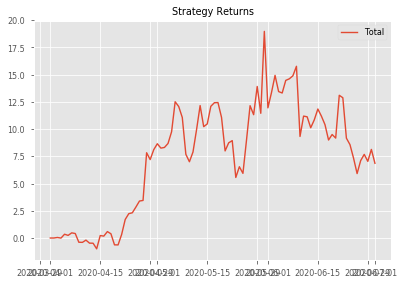

In [30]:
with plt.style.context(['ggplot','seaborn-paper']):
    #Plotting trade_dataset Value   
    plt.plot(positions['Date'],positions['Total'])
    
    plt.title('Strategy Returns')
    plt.legend(loc=0)
    plt.show()

Looks like the strategy did rather well - despite large drawdowns sometimes. But the time period of this backtest isn't very long.\
Note that the Adj Close values had been normalised previously.